# Imports

In [1]:
import os
from itertools import groupby

from datetime import datetime, timedelta
import numpy as np

import cartopy as cp
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import matplotlib.patheffects as peffects
import matplotlib.dates as mdates
import matplotlib.axes._subplots as subplot

from spacepy import coordinates as coord

In [2]:
from classes import Riometer, HyperSpectralRiometer, IrisRiometer, LaJollaRiometer
from utils import load_object

In [3]:
riometer_list = load_object("Riometer_List")

In [4]:
la_jolla_riometers = [rio for rio in riometer_list if rio.riometer_type == "La Jolla"]

riometers = {}

for rio in la_jolla_riometers:
    riometers[rio.name] = rio

print("{" + "\n \n".join("{!r}: {!r},".format(k, v) for k, v in riometers.items()) + "}")

{'Dawson, YK': LaJollaRiometer(name='Dawson, YK', tag='daws', lon=-139.43, lat=64.05, status='Currently Operating', riometer_type='La Jolla'),
 
'Churchill, MB': LaJollaRiometer(name='Churchill, MB', tag='chur', lon=-94.08, lat=58.76, status='Currently Operating', riometer_type='La Jolla'),
 
'Fort Smith, NWT': LaJollaRiometer(name='Fort Smith, NWT', tag='fsmi', lon=-111.88, lat=60, status='Currently Operating', riometer_type='La Jolla'),
 
'Pinwa, MB': LaJollaRiometer(name='Pinwa, MB', tag='pina', lon=-95.88, lat=50.15, status='Currently Operating', riometer_type='La Jolla'),
 
'Rankin Inlet, NU': LaJollaRiometer(name='Rankin Inlet, NU', tag='rank', lon=-92.085, lat=62.81, status='Currently Operating', riometer_type='La Jolla'),
 
'Taloyoak, NU': LaJollaRiometer(name='Taloyoak, NU', tag='talo', lon=-93.53, lat=69.54, status='Currently Operating', riometer_type='La Jolla'),
 
'Fort Simpson, NWT': LaJollaRiometer(name='Fort Simpson, NWT', tag='fsim', lon=-121.35, lat=61.86, status='Curr

# Map

In [5]:
class OrthoMap:
    
    def __init__(self, central_riometer, radius, r_padding, title, 
                        width = 900, height = 900, dpi = 200, resolution = '50m',
                        lon_shift =0, lat_shift=0) -> None:
        
        self.central_lon, self.central_lat = central_riometer.lon, central_riometer.lat
        
        self.radius    = radius
        self.r_padding = r_padding
        
        self.width      = width
        self.height     = height
        self.dpi        = dpi
        self.resolution = resolution
        
        self.lon_shift = lon_shift
        self.lat_shift = lat_shift

        self.title = title

        self.__post_init__()
        
    def __post_init__(self):
        
        self.ortho = cp.crs.Orthographic(central_longitude=self.central_lon + self.lon_shift, central_latitude=self.central_lat + self.lat_shift)
        self.pad_radius = self.compute_radius(self.radius + self.r_padding)
        
    
    
    def compute_radius(self, radius_degrees):

        theta1 = self.central_lon + radius_degrees if self.central_lon <= 0 else self.central_lon - radius_degrees
        phi    = self.central_lat + radius_degrees if self.central_lat <= 0 else self.central_lat - radius_degrees

        x, y = self.ortho.transform_point(self.central_lon, phi, cp.crs.PlateCarree())

        return np.sqrt( (x)**2 + (y)**2 )

    def plot_features(self, ax):
        
        ax.imshow(np.tile(np.array([[cp.feature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]), origin='upper', transform=cp.crs.PlateCarree(), 
                                                                        extent=[-180, 180, -180, 180], alpha=0.9)
        ax.add_feature(cp.feature.NaturalEarthFeature('physical', 'land', self.resolution, edgecolor='black', facecolor=cp.feature.COLORS['land']), alpha=0.7)
        ax.add_feature(cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', self.resolution, edgecolor='black', facecolor='none', alpha=0.3 ))
        ax.add_feature(cp.feature.NaturalEarthFeature('physical', 'lakes', self.resolution, edgecolor='none', facecolor=cp.feature.COLORS['water']), alpha=0.1)
        ax.add_feature(cp.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', self.resolution, edgecolor=cp.feature.COLORS['water'], facecolor='none', alpha=0.1))
        # ax.add_feature(cp.feature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', self.resolution, edgecolor='gray', facecolor='none', alpha=0.1))
        
    
    def format_grid(self, ax):
        
        gl = ax.gridlines(crs=cp.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, linestyle='--', draw_labels=False, x_inline=False, y_inline=False)
        gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
        gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
        
        gl.xlabel_style = {'size': 10, 'color': 'gray', 'ha':'right'}
        gl.ylabel_style = {'size': 10, 'color': 'gray', 'multialignment':'left'}
        
        gl.xlocator = mticker.FixedLocator([-180.0, -150.0, -120.0, -90.0, -60.0, -30.0, 0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0])
        gl.ylocator = mticker.FixedLocator([ -90.0, -70.0, -50.0, -30.0, -10.0, -5.0, 0.0, 5.0, 10.0, 30.0, 50.0, 70.0, 90.0])
        
        gl.top_labels = False
        gl.bottom_labels =True
        gl.right_labels= False
        gl.left_labels = True
        
    
    def show_map(self):
        self.fig = plt.figure(figsize=(self.width / self.dpi, self.height / self.dpi), dpi=self.dpi)
        self.ax = self.fig.add_subplot(1, 1, 1, projection=self.ortho)
        
        self.transform = cp.crs.PlateCarree()._as_mpl_transform(self.ax)
        
        
        self.ax.set_title(self.title)
        
        self.ax.set_xlim([-self.pad_radius , self.pad_radius ])
        self.ax.set_ylim([-self.pad_radius , self.pad_radius ])
        
        self.plot_features(self.ax)
        self.format_grid(self.ax)
        
        self.map_drawn = True
        
    def show_riometers(self, riometer_list, color):
        
        self.show_map() if not self.map_drawn else None
        
        for rio in riometer_list:
            self.ax.scatter( rio.lon, rio.lat, marker = 'o', transform = self.transform,
                                                s = 30, edgecolor='black', facecolor = color, zorder=10)
            
            
            ann = self.ax.annotate( rio.tag, (rio.lon +1, rio.lat +1), xycoords=self.transform, 
                                                                    fontsize=10, style='italic')
            ann.set_path_effects([peffects.withStroke(linewidth=1.5, foreground="#EEBF73")])
        
            
    def show_path(self, path_start_name, path_start_coords, path_finish_name, path_finish_coords):
        
        self.show_map() if not self.map_drawn else None
        
        for coords in [path_start_coords, path_finish_coords]:
            self.ax.scatter( *coords, marker = 'o', transform = self.transform,
                                                s = 30, edgecolor='#EEBF73', facecolor = "#4D3610", zorder=10)
            
        offset = np.array([1, -2])
        
        start = self.ax.annotate(path_finish_name, xy=np.array(path_finish_coords) - offset, xycoords=self.transform, textcoords=self.transform, ha='right', va='top')

        finish = self.ax.annotate(path_start_name, xy=path_finish_coords, xytext=np.array(path_start_coords) - offset,
                            arrowprops=dict(facecolor='#CFC2AD', edgecolor="#39280D",
                                    arrowstyle="simple",
                                    connectionstyle="arc3,rad=-0.2",
                                    alpha=0.6),
                    xycoords=self.transform, textcoords=self.transform,
                    ha='right', va='top')
        
        start.set_path_effects([peffects.withStroke(linewidth=1.5, foreground="#EECF9B")])
        finish.set_path_effects([peffects.withStroke(linewidth=1.5, foreground="#EECF9B")])
        
        


c:\Users\philo\.conda\envs\data_env\lib\site-packages\cartopy\mpl\gridliner.py:531: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
c:\Users\philo\.conda\envs\data_env\lib\site-packages\cartopy\mpl\gridliner.py:543: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:
c:\Users\philo\.conda\envs\data_env\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
c:\Users\philo\.conda\envs\data_env\lib\s

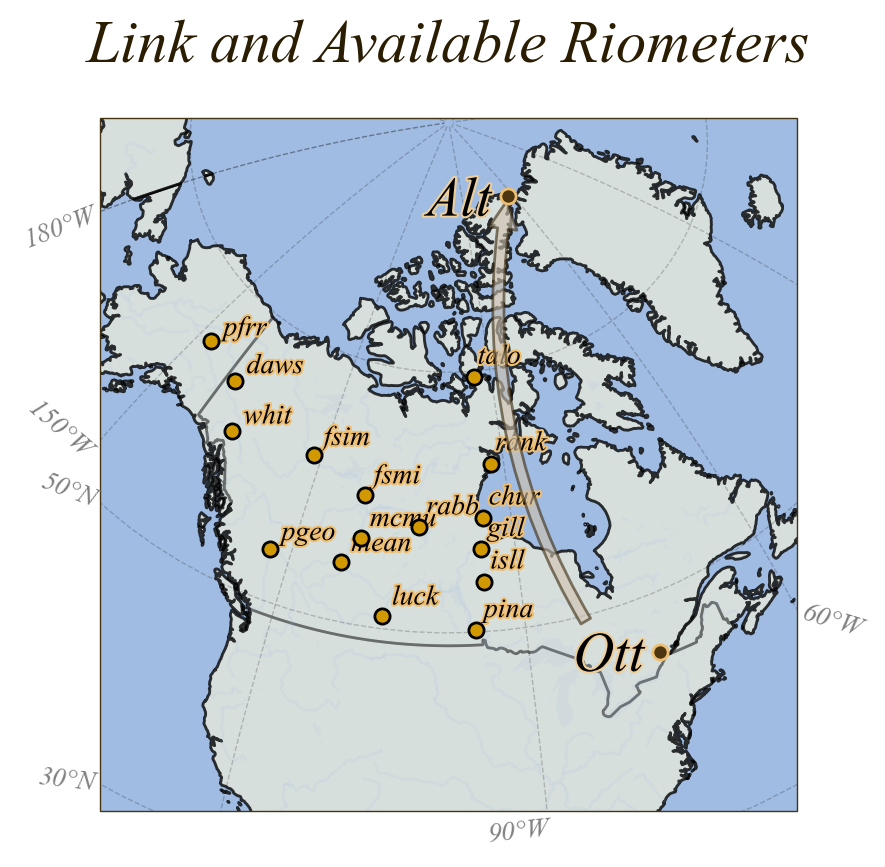

In [6]:
central_riometer = riometers['Lucky Lake, SK']

geo_map = OrthoMap(central_riometer, radius=10, r_padding=5, title="Link and Available Riometers", lat_shift=12, lon_shift=8)
geo_map.show_map()
geo_map.show_riometers([rio for rio in riometer_list if  rio.tag.islower()], "#D19800")
geo_map.show_path("Ott", ( - 75.69, 45.42 ), "Alt", ( - 62.35, 82.50))


# Data Analysis

In [7]:
chosen_riometers = [riometers[key] for key in ['Taloyoak, NU', "Churchill, MB", "Rankin Inlet, NU"] ]
chosen_riometers = sorted(chosen_riometers, key=lambda r: r.lat, reverse=True)
chosen_riometers

[LaJollaRiometer(name='Taloyoak, NU', tag='talo', lon=-93.53, lat=69.54, status='Currently Operating', riometer_type='La Jolla'),
 LaJollaRiometer(name='Rankin Inlet, NU', tag='rank', lon=-92.085, lat=62.81, status='Currently Operating', riometer_type='La Jolla'),
 LaJollaRiometer(name='Churchill, MB', tag='chur', lon=-94.08, lat=58.76, status='Currently Operating', riometer_type='La Jolla')]

In [8]:
data_dir = "\\\\bender.phys.ucalgary.ca\\data\\go\\go-rio\\txt\\"

from classes import DataFile, DataOrganizer

In [9]:
for year in [2013, 2014, 2016, 2017, 2019]:
    organizer = DataOrganizer(year)
    fig, axs = organizer.show_data_availability(show_ind_days=False, minor_label_size=15)

    plt.savefig("plots\\data_availability\\%.4d.png" % (year))
    plt.close()
    

In [10]:
organizer = DataOrganizer(2013)

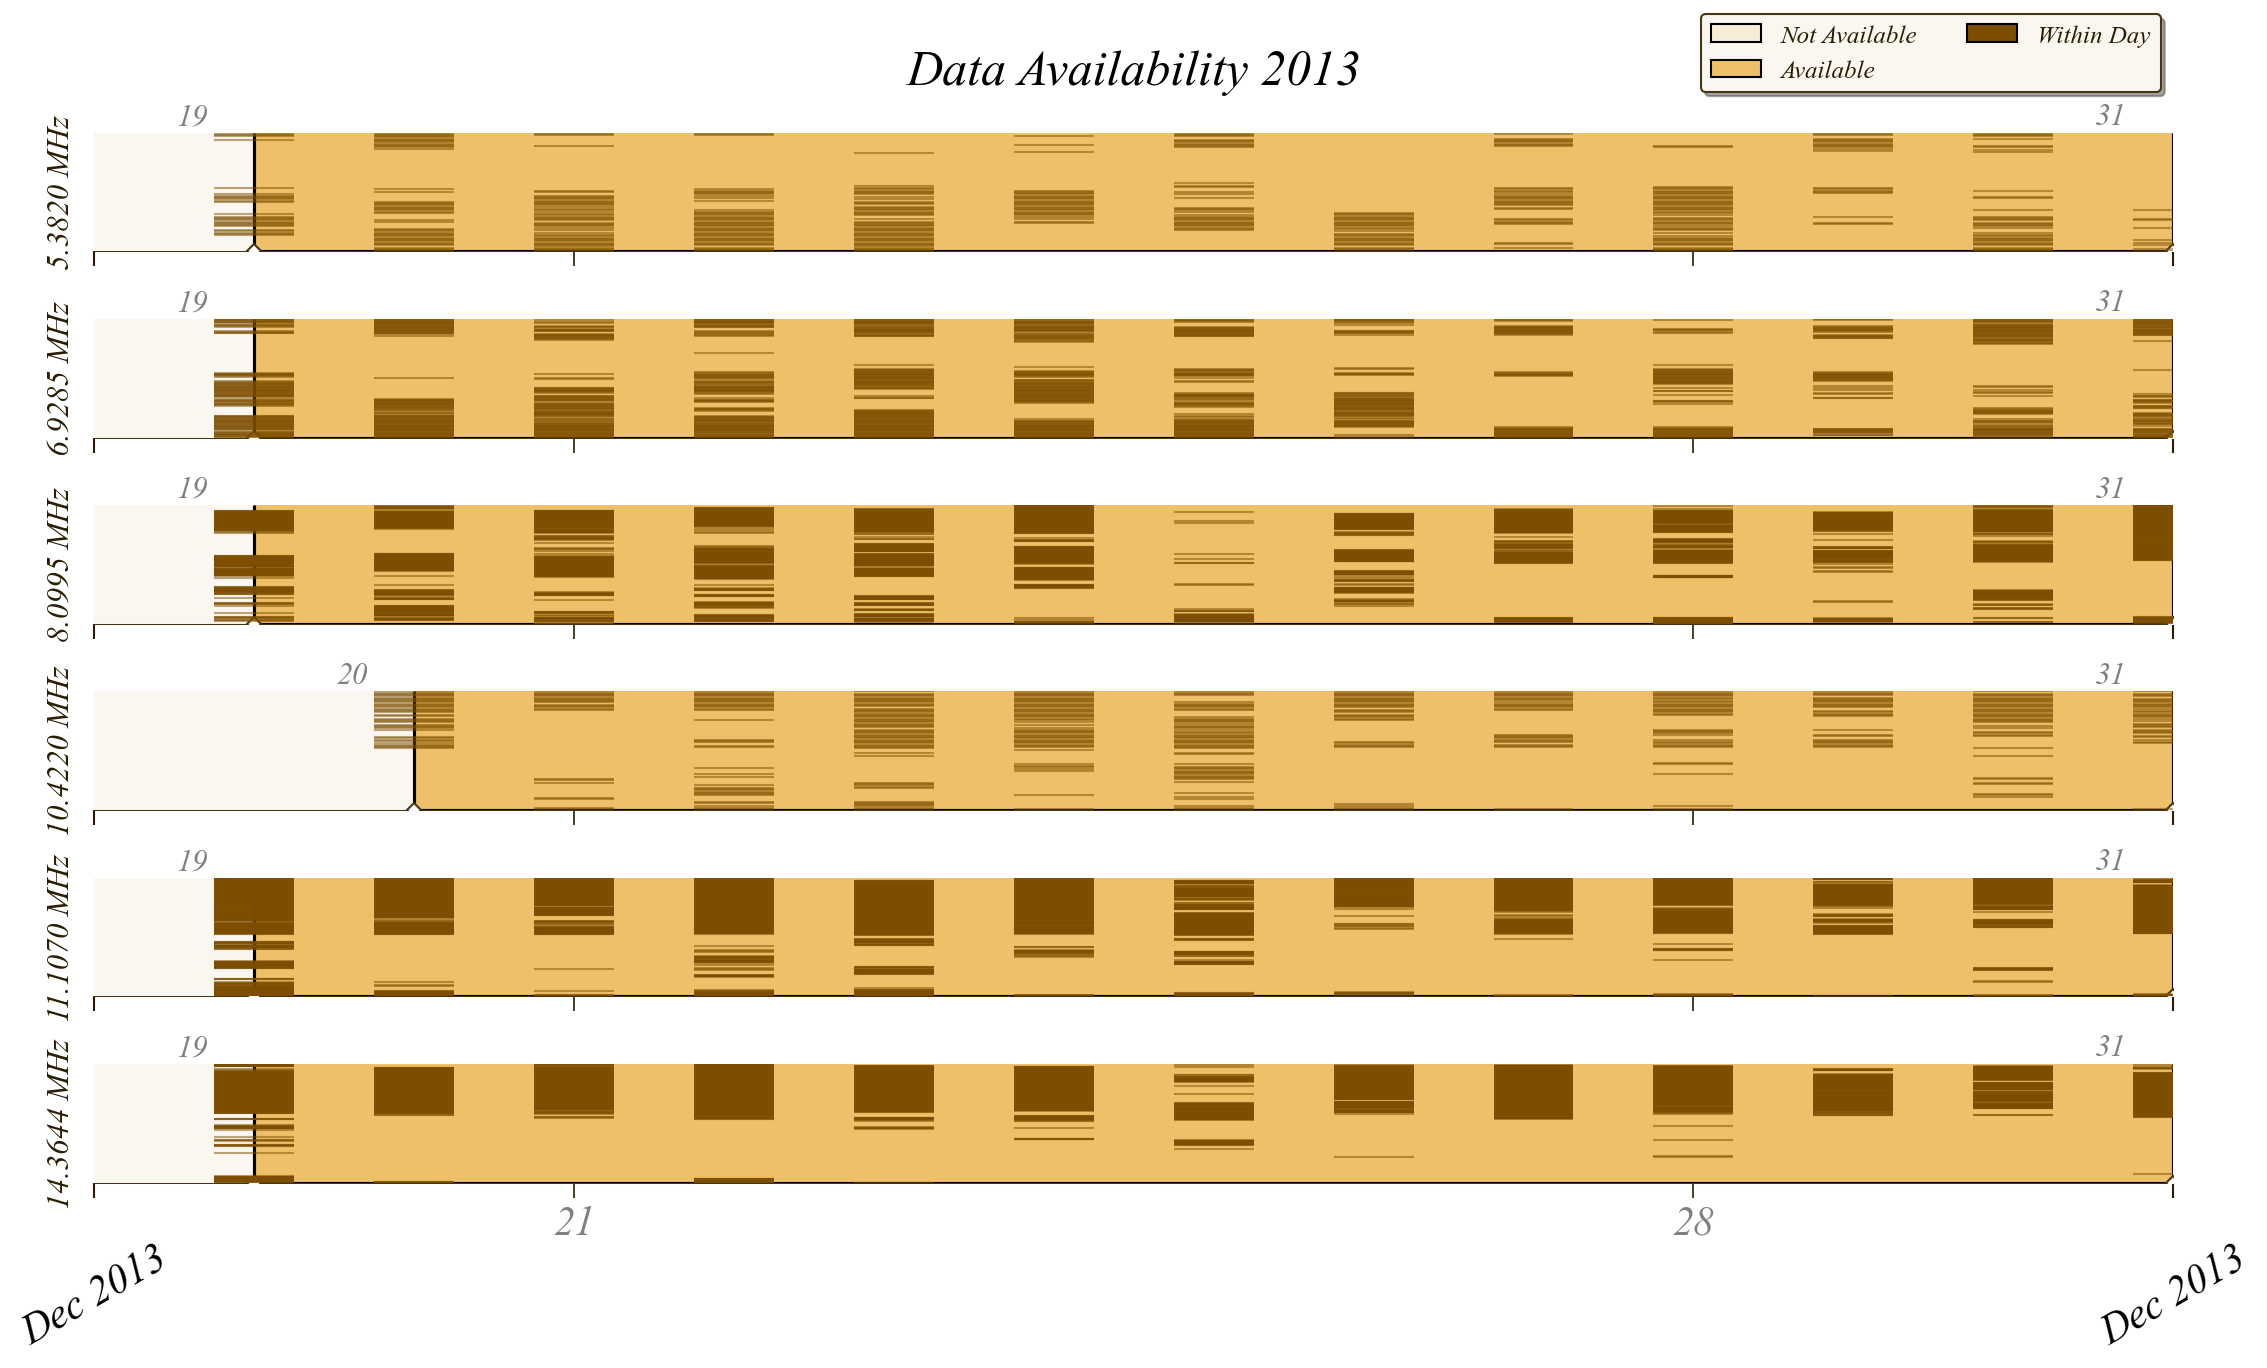

In [11]:
fig, axs = organizer.show_data_availability(show_ind_days=True, minor_label_size=20)

In [11]:
f_max = organizer.find_freq_max_days()
# TODO: Deal with days and day ranges that are not in the time_keeper with the maximum number of days
print(f_max, organizer.time_keeper[f_max])


11.107 ([datetime.datetime(2019, 7, 20, 0, 0), datetime.datetime(2019, 7, 23, 0, 0), datetime.datetime(2019, 9, 17, 0, 0), datetime.datetime(2019, 9, 26, 0, 0), datetime.datetime(2019, 10, 1, 0, 0), datetime.datetime(2019, 10, 6, 0, 0), datetime.datetime(2019, 10, 12, 0, 0), datetime.datetime(2019, 10, 20, 0, 0)], [datetime.datetime(2019, 9, 28, 0, 0)], datetime.timedelta(days=26))


In [12]:

# * This is for pulling data later  * #
days, odd_days, _ = organizer.time_keeper[f_max]

day_pairs = [ (days[i], days[i+1]) for i, element in enumerate(days) if i < len(days) -1 ][::2]

all_days = []
data_paths = {}
for rio in chosen_riometers:

    paths = []
    for day_pair in day_pairs:
        
        start_day, end_day = day_pair
        
        while start_day < end_day + timedelta(days=1):
            
            txt_file_path = "%s%s\\norstar_k0_rio-%s_%s_v01.txt" % (data_dir, start_day.strftime("%Y\\%m\\%d"), rio.tag, start_day.strftime("%Y%m%d"))
            if os.path.isfile(txt_file_path): paths.append(txt_file_path)

            all_days.append(start_day)
            start_day += timedelta(days=1)
            
        for day in odd_days:
            
            
            txt_file_path = "%s%s\\norstar_k0_rio-%s_%s_v01.txt" % (data_dir, day.strftime("%Y\\%m\\%d"), rio.tag, day.strftime("%Y%m%d"))
            if os.path.isfile(txt_file_path): paths.append(txt_file_path)
            
            all_days.append(day)
    
    data_paths[rio.tag] = paths

In [13]:
# link_path = "Ott_Alt"
# year = 2019

# for day in all_days:
    
#     plot_dir = "plots\\riometers_on_path\\%s\\%4d" % (link_path, year)
#     plot_path = "%s\\%s.png" % (plot_dir, day.strftime("%Y_%m_%d"))
    
#     if not os.path.isdir(plot_dir): os.makedirs(plot_dir)
    
#     fig, axs = plt.subplots(len(chosen_riometers), 1, figsize=(12, len(chosen_riometers)*2.5), dpi=200, sharex=True, constrained_layout=False)
#     fig.suptitle( "Chosen Riometers: " + day.strftime("%Y-%m-%d"))
#     fig.set_tight_layout(2)
    
#     axs[-1].set_xlabel("Time (UTC)")
#     for rio, ax in zip(chosen_riometers, axs):
        
#         txt_file_path = "%s%s\\norstar_k0_rio-%s_%s_v01.txt" % (data_dir, day.strftime("%Y\\%m\\%d"), rio.tag, day.strftime("%Y%m%d"))
        
#         try:
#             data = np.loadtxt(txt_file_path, dtype=str)
#             date, time, raw = data.T
#             print(date, time)
            
#             time_array = np.array([datetime.strptime(d[:-2] +"20" + d[-2:] + t, "%d/%m/%Y%H:%M:%S") for d, t in zip(date[:-1], time[:-1])])
#             raw_array = np.float32(raw)[:-1]
            
            
#         except Exception as e:
#             print(e)
            
        
#         ax.plot(time_array, raw_array, lw = 0.5, marker="D", ms=1, mfc="#BC3232", mec="#BC3232", color="#BC3232", alpha = 0.9)
        
#         ax.set_xlim(time_array[[0, -1]])
#         ax.set_ylim( np.median(raw_array) - 2.5, np.median(raw_array) + 2.5 )
        
#         ax.xaxis.set_major_locator(mdates.HourLocator( byhour=np.arange(0, 24.5, 2) ) )
#         ax.xaxis.set_major_formatter( mdates.DateFormatter("%H:%M") )
        
#         ax.xaxis.set_tick_params(which="both", rotation=30)
        
#         ax.set_ylabel("Voltage (V)")
#         ax.set_title(rio.tag)
        
#     plt.savefig(plot_path)
#     plt.close()
        
        
        
        
    

In [14]:
absorption_days = [ 
                    (22, 7),
                    (23, 7),
                    (21, 9), # Clear Injection
                    (28, 9), # Multiple Substorms
                    (1, 10),
                    (2, 10),
                    (4, 10),
                    (6, 10),
                    (17, 10),
                ]

interesting_times = [ datetime(2019, m, d) for d, m in absorption_days ]

## Correlating Absorption with signal reception

In [15]:
files_to_plot = []
for freq in organizer.data_dic:
    file_list = organizer.data_dic[freq]
    
    for data_file in file_list:
        if data_file.date_time in interesting_times:
            files_to_plot.append(data_file)
            

files_to_plot = sorted(files_to_plot, key= lambda x: x.date_time, reverse=False)
files_by_day  = [list(g) for k, g in groupby(files_to_plot, key=lambda file: file.date_time)]

In [16]:
plot_dir = "plots\\snr\\Ott_Alt\\2019"
if not os.path.isdir(plot_dir): os.makedirs(plot_dir)

for file_group in files_by_day:
        fig, axs = plt.subplots(len(file_group), 1, figsize=(15, len(file_group)*2.5), constrained_layout=False, sharex=True)
        fig.set_facecolor('w')
        fig.suptitle("Signal-to-Noise Ratio: Ott-Alert Link, %s" % ( file_group[0].date_time.strftime("%Y-%m-%d")))
        
        axs = [axs] if isinstance(axs, subplot.Axes) else axs
        axs[-1].set_xlabel("Hour (UT)")
        plot_path = "%s\\%s.png" % (plot_dir, file_group[0].date_time.strftime("%Y_%m_%d"))
        
        for file, ax in zip(file_group, axs):
                
                snr  = file.data_dic['snr']
                time = file.time_arr
                
                ax.plot(time, snr, color='r', mec='r', mfc='r', ms=5)
                ax.set_title("%.4f MHz" % (file.frequency))
                ax.set_ylabel("SNR [dB]")
                ax.set_xticks(np.arange(0, 25, 2))
                ax.set_xlim(0, 24)
                
        plt.savefig(plot_path)
        plt.close()

[ 1.13504593  3.51117601  4.20596847  6.60222468  2.05618336  2.00302458
  2.8855887   1.18612116  0.79096849  1.76814085  2.14021098  3.65239378
  1.67095699  5.0981269   1.36698606  1.53041619  2.99942436  0.93208988
  0.62663809  0.594585    0.33504698  0.3729895   0.27407685  1.40415529
  0.54947186  0.95911719  1.24266472  2.35941318  0.6134538   0.85488725
  0.66974439  0.72095697  1.37812131 16.49506667  5.31232908  4.94874833
  6.98879149  3.4994299   1.75953068  2.73865983  3.62866902  2.6948592
  0.76976656  0.41508648  2.63964877  0.91854721  0.6888694   0.44461052
  0.44798708  0.68963811  1.56561777  0.27043287  1.89398628  0.9347593
  2.96525527  0.89257465  0.86889458  1.52120352  0.93806535  0.68779118
  0.65880939  1.17868815  0.91204517  0.90630711  0.73072364  1.39310985] [0.035 0.16  0.285 0.41  0.535 0.66  0.785 1.035 1.16  1.285 1.41  1.535
 1.66  1.785 1.91  2.035 2.16  2.285 2.41  3.535 4.035 4.16  4.285 4.41
 4.535 4.66  4.785 4.91  5.035 5.16  5.285 5.41  5.53

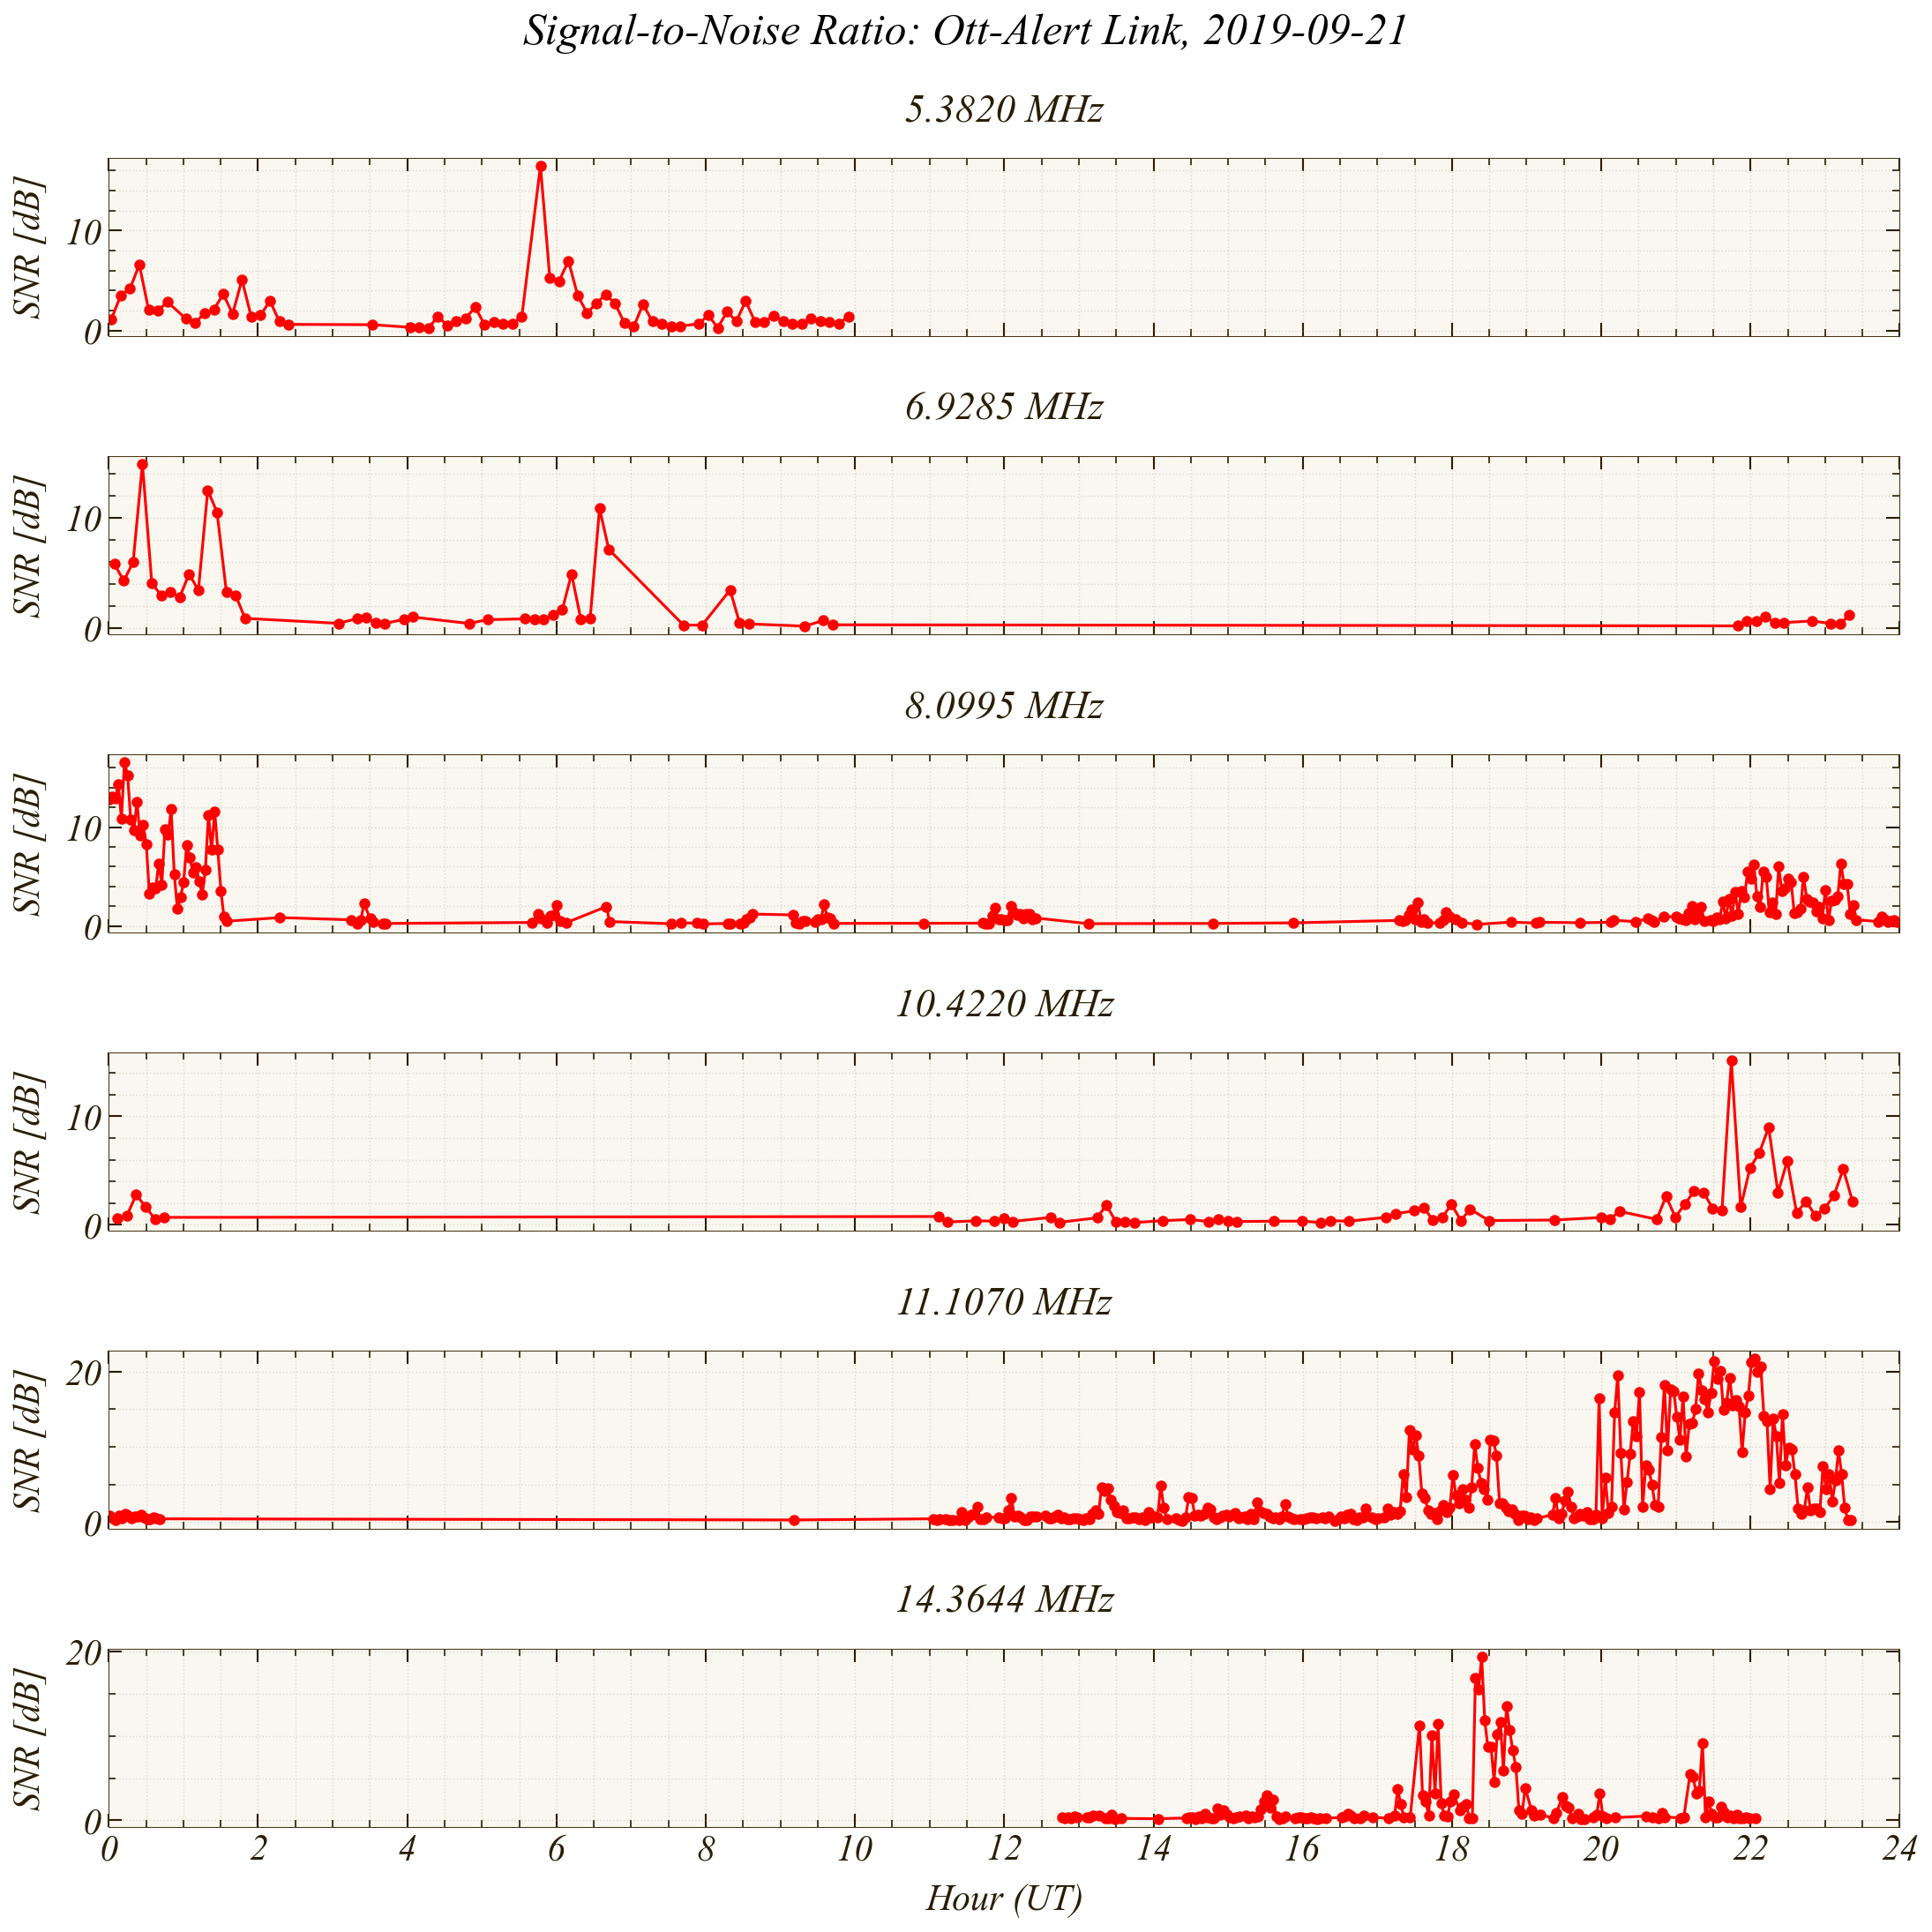

In [15]:



plot_dir = "plots\\snr\\Ott_Alt\\2019"
if not os.path.isdir(plot_dir): os.makedirs(plot_dir)

fig, axs = plt.subplots(len(organizer.data_dic), 1, figsize=(15, len(organizer.data_dic)*2.5), constrained_layout=False, sharex=True)
axs[-1].set_xlabel("Hour (UT)")


for freq, ax in zip( organizer.data_dic, axs):
    
    file_list = organizer.data_dic[freq]
    
    for data_file in file_list:
        if data_file.date_time in interesting_times:
            
            fig.suptitle("Signal-to-Noise Ratio: Ott-Alert Link, %s" % (data_file.date_time.strftime("%Y-%m-%d")))
            plot_path = "%s\\%s.png" % (plot_dir, day.strftime("%Y_%m_%d"))
        
            snr  = data_file.data_dic['snr']
            time = data_file.time_arr
            
            ax.plot(time, snr, color='r', mec='r', mfc='r', ms=5)
    
    ax.set_title("%.4f MHz" % (freq))
    ax.set_ylabel("SNR [dB]")
    
    ax.set_xticks(np.arange(0, 25, 2))
    ax.set_xlim(0, 24)
        
    


[2.7 3.2 3.4 3.7 3.  1.9 1.8 2.8 2.3 2.6 2.5 2.4 2.7 3.3 2.  2.7 2.5 3.3
 2.7 1.9 1.9 1.8 1.8 1.8 2.2 2.  2.  2.  2.  1.9 1.9 1.8 1.9 1.9 1.8 1.9
 1.9 1.9 2.  1.9 2.  2.  2.  2.  2.  1.9 1.9 2.  1.9 1.9 1.9 2.  1.9 1.9
 2.  1.9 1.9 1.9 1.8 1.9 1.8 1.9 1.9 1.9 1.8 1.9] [0.035 0.16  0.285 0.41  0.535 0.66  0.785 1.035 1.16  1.285 1.41  1.535
 1.66  1.785 1.91  2.035 2.16  2.285 2.41  3.535 4.035 4.16  4.285 4.41
 4.535 4.66  4.785 4.91  5.035 5.16  5.285 5.41  5.535 5.785 5.91  6.035
 6.16  6.285 6.41  6.535 6.66  6.785 6.91  7.035 7.16  7.285 7.41  7.535
 7.66  7.91  8.035 8.16  8.285 8.41  8.535 8.66  8.785 8.91  9.035 9.16
 9.285 9.41  9.535 9.66  9.785 9.91 ]
[2.6 2.5 2.5 2.5 2.4 2.6 2.4 2.3 2.3 2.2 2.1 2.2 2.2 2.5 2.6 2.  1.9 1.9
 1.9 1.9 1.7 1.9 2.  2.  2.  1.9 1.9 1.9 2.  2.  2.  2.  2.  2.  1.8 1.8
 2.  2.  1.9 1.8 1.9 2.  3.9 3.6 3.4 3.  3.6 3.2 2.1 2.2 2.2 2.5] [ 0.07666666  0.20166667  0.32666667  0.45166667  0.57666667  0.70166667
  0.82666666  0.95166667  1.07666666  1.20166

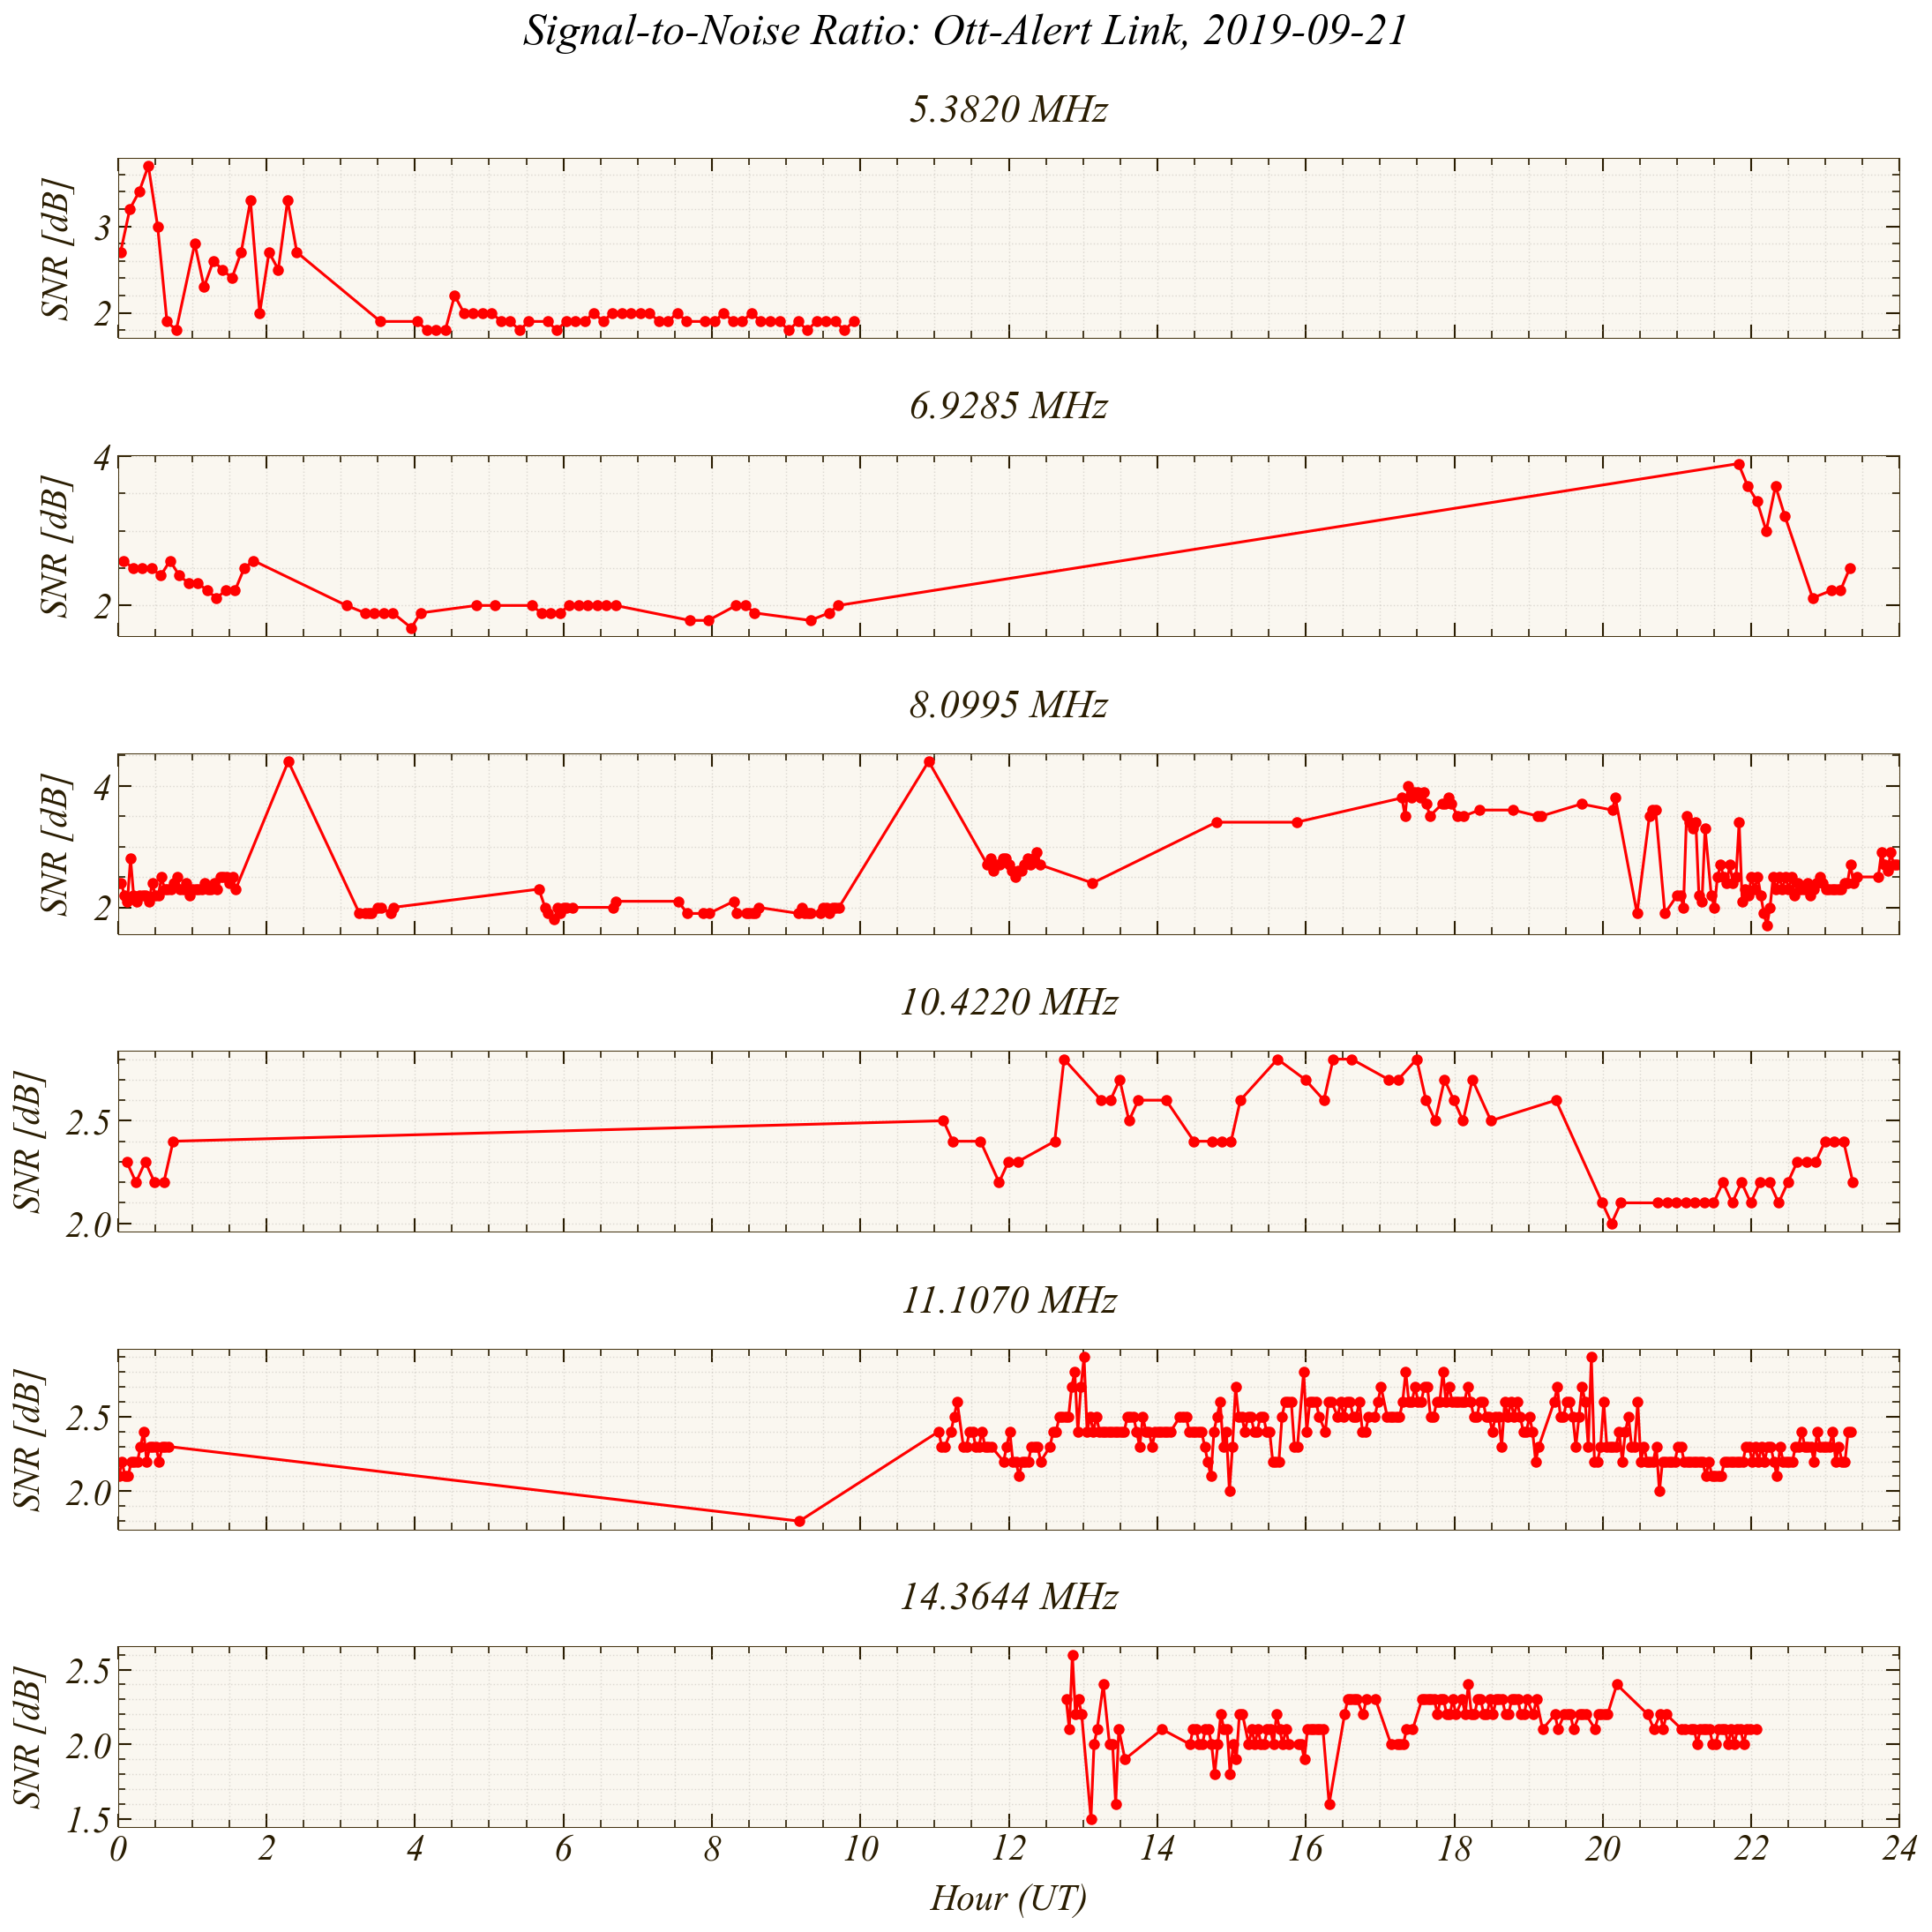

In [16]:


fig, axs = plt.subplots(len(organizer.data_dic), 1, figsize=(15, len(organizer.data_dic)*2.5), constrained_layout=False, sharex=True)
axs[-1].set_xlabel("Hour (UT)")

fig.suptitle("Signal-to-Noise Ratio: Ott-Alert Link, 2019-09-21")

for freq, ax in zip( organizer.data_dic, axs):
    
    file_list = organizer.data_dic[freq]
    
    for data_file in file_list:
        
        if data_file.date_time == datetime(2019, 9, 21):
        
            tof = data_file.data_dic['toflight']
            time = data_file.time_arr
            
            print(tof, time)
            ax.plot(time, tof, color='r', mec='r', mfc='r', ms=5)
    
    ax.set_title("%.4f MHz" % (freq))
    ax.set_ylabel("SNR [dB]")
    
    ax.set_xticks(np.arange(0, 25, 2))
    ax.set_xlim(0, 24)
    

